In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import ast
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

### Prediccion de tags usando KNN-Multietiqueta

#### Datos

In [84]:
data = pd.read_csv('../../data/en_CTP10_tokenized.csv')
data.head()

,Unnamed: 0,time_limit,memory_limit,description,tags,language,tokenized_description
0,1616/E,1.0,256.0,give two string $$$ s $$$ $$$ t $$$ equal leng...,"['bruteforce', 'datastructures', 'greedy', 'st...",en,"[0, 26650, 80, 6755, 68, 42654, 579, 68, 42654..."
1,900/A,1.0,256.0,n distinct point a plane none lie oy axis chec...,"['geometry', 'implementation']",en,"[0, 282, 11693, 477, 10, 3286, 4146, 6105, 231..."
2,702/F,4.0,1024.0,big consignment t - shirts go sale shop begin ...,['datastructures'],en,"[0, 8527, 7407, 15645, 326, 111, 15331, 213, 1..."
3,181/A,2.0,256.0,berland capital shake three bold crimes commit...,"['bruteforce', 'geometry', 'implementation']",en,"[0, 1943, 1245, 812, 8559, 130, 7457, 3474, 62..."
4,1352/A,1.0,256.0,a positive ( strictly greater zero ) integer c...,"['implementation', 'math']",en,"[0, 102, 1313, 36, 14657, 2388, 4276, 4839, 48..."


### Exploración de datos

#### Revisamos la informacion de los datos para verificar si hay nulls y los tipos de datos de las columnas

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1624 non-null   object 
 1   time_limit             1624 non-null   float64
 2   memory_limit           1624 non-null   float64
 3   description            1624 non-null   object 
 4   tags                   1624 non-null   object 
 5   language               1624 non-null   object 
 6   tokenized_description  1624 non-null   object 
dtypes: float64(2), object(5)
memory usage: 88.9+ KB


#### Convertimos la descripcion de los problemas en informacion numerica, ya que es necesarion para poder entrenar un modelo KNN  

In [86]:
vectorizer = TfidfVectorizer()
vectorizer.fit(data['description'])
tfidf_matrix = vectorizer.transform(data['description'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

#### Eliminamos las columnas que no aportan informacion relevante

In [87]:
data.drop(columns=['description'], inplace=True)
data.drop(columns=['Unnamed: 0'], inplace=True)
data.drop(columns=['language'], inplace=True)
data.drop(columns=['tokenized_description'], inplace=True)

In [88]:
data.head()

,time_limit,memory_limit,tags
0,1.0,256.0,"['bruteforce', 'datastructures', 'greedy', 'st..."
1,1.0,256.0,"['geometry', 'implementation']"
2,4.0,1024.0,['datastructures']
3,2.0,256.0,"['bruteforce', 'geometry', 'implementation']"
4,1.0,256.0,"['implementation', 'math']"


#### Convertimos los strings de la columna tags en listas de tags

In [89]:
data['tags'] = data['tags'].apply(lambda x: ast.literal_eval(x))

In [90]:
data.head()

,time_limit,memory_limit,tags
0,1.0,256.0,"[bruteforce, datastructures, greedy, strings]"
1,1.0,256.0,"[geometry, implementation]"
2,4.0,1024.0,[datastructures]
3,2.0,256.0,"[bruteforce, geometry, implementation]"
4,1.0,256.0,"[implementation, math]"


#### Añadimos a nuestros datos una matriz binaria con la informacion de los tags por problema y eliminamos la columna tags

In [91]:

all_tags = set([tag for tags_list in data['tags'] for tag in tags_list])
for tag in all_tags:
    data[tag] = 0

for index, row in data.iterrows():
    for tag in row['tags']:
        data.loc[index, tag] = 1   

data = data.drop('tags', axis=1)  

In [92]:
data.head()

,time_limit,memory_limit,bruteforce,greedy,math,datastructures,implementation,strings,dp,geometry,dfsandsimilar,constructivealgorithms
0,1.0,256.0,1,1,0,1,0,1,0,0,0,0
1,1.0,256.0,0,0,0,0,1,0,0,1,0,0
2,4.0,1024.0,0,0,0,1,0,0,0,0,0,0
3,2.0,256.0,1,0,0,0,1,0,0,1,0,0
4,1.0,256.0,0,0,1,0,1,0,0,0,0,0


#### Creamos nuestro vector Y con la matriz binaria de tags y eliminamos dicha matriz de los datos

In [93]:
y = data[list(all_tags)]
for tag in all_tags:
    data = data.drop(tag, axis=1)  
 

#### Concatenamos a nuestros datos el vector de TF-IDF

In [94]:
data = pd.concat([data, tfidf_df], axis=1)

In [95]:
data.head()

,time_limit,memory_limit,00,000,0000,00000,0000000,00000000,000000011,000001,...,zyxaabcaabkjh,zz,zzaa,zzcxx,zzz,zzzb,αβ,βr,βrα,сi
0,1.0,256.0,0.0,0.073442,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,256.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,1024.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,256.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,256.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
y.head()

,bruteforce,greedy,math,datastructures,implementation,strings,dp,geometry,dfsandsimilar,constructivealgorithms
0,1,1,0,1,0,1,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,1,0,0,1,0,0
4,0,0,1,0,1,0,0,0,0,0


### Entrenamiento del modelo

#### Separamos los datos en entrenamiento, validacion y prueba

In [98]:
X_train,X_test,y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

X_train,X_validation,y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [112]:
print(f"Training set: {X_train.shape[0]} rows")
print(f"Validation set: {X_validation.shape[0]} rows")
print(f"Test set: {X_test.shape[0]} rows")

Training set: 974 rows
Validation set: 325 rows
Test set: 325 rows


#### Entrenamiento del modelo

In [103]:
classifier = KNeighborsClassifier(n_neighbors=8)
multilabel_knn = MultiOutputClassifier(classifier)
multilabel_knn.fit(X_train, y_train)

MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=8))

### Evaluación del modelo

In [100]:
from sklearn.metrics import  classification_report, accuracy_score


#### Prediccion del modelo

In [104]:
y_pred = multilabel_knn.predict(X_test)


**Cómo seleccionar el valor de k?: Ajuste de hiperparámetros**



El ajuste de hiperparámetros es cuando se pasa por un proceso para encontrar los parámetros óptimos para su modelo para mejorar la precisión.

In [101]:
neighbors = np.arange(1, 100)
train_accuracies = {}
validation_accuracies = {}
reports = []
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    mlb_knn = MultiOutputClassifier(knn)
    mlb_knn.fit(X_train, y_train)
    ypred = mlb_knn.predict(X_validation) 
    train_accuracies[neighbor] = mlb_knn.score(X_train, y_train)
    validation_accuracies[neighbor] = mlb_knn.score(X_validation, y_validation)
    reports.append(classification_report(y_validation, ypred, zero_division = 0))


Buscando el mejor K entre 1 y 100 a partir de los resultados

In [102]:
from sklearn.metrics import classification_report

best_index = 0
best_mean = 0
# Parsea el informe de clasificación
for i in range(99):
    classification_report_lines = reports[i].split('\n')
    macro_avg_line = float(classification_report_lines[-4].split()[2])
    weighted_avg_line = float(classification_report_lines[-3].split()[2])
    samples_avg_line = float(classification_report_lines[-2].split()[2])
    mean = np.mean([macro_avg_line, weighted_avg_line, samples_avg_line])
    if(mean > best_mean):
        best_index = i
        best_mean = mean


print(best_mean)
print(best_index)

0.4266666666666666
8


#### Exploracion de resultados

In [105]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0, target_names=list(all_tags))
report_df = pd.DataFrame(report).transpose()
print(accuracy_score(y_test, y_pred))

0.07076923076923076


In [106]:
avgs=['weighted avg', 'macro avg', 'micro avg', 'samples avg']

for index_name in avgs:
    row = report_df.loc[index_name]
    print(f"{index_name.capitalize()} Metrics:")
    for metric_name, value in row.items():
        print(f"  {metric_name.capitalize()}: {value:.2f}")
    print()

Weighted avg Metrics:
  Precision: 0.45
  Recall: 0.19
  F1-score: 0.26
  Support: 635.00

Macro avg Metrics:
  Precision: 0.35
  Recall: 0.16
  F1-score: 0.21
  Support: 635.00

Micro avg Metrics:
  Precision: 0.50
  Recall: 0.19
  F1-score: 0.27
  Support: 635.00

Samples avg Metrics:
  Precision: 0.29
  Recall: 0.20
  F1-score: 0.22
  Support: 635.00



In [107]:
report_df.drop(avgs, axis=0, inplace=True)
print(report_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
bruteforce & 0.428571 & 0.049180 & 0.088235 & 61.000000 \\
greedy & 0.437500 & 0.252252 & 0.320000 & 111.000000 \\
math & 0.411765 & 0.138614 & 0.207407 & 101.000000 \\
datastructures & 0.631579 & 0.244898 & 0.352941 & 49.000000 \\
implementation & 0.666667 & 0.253521 & 0.367347 & 142.000000 \\
strings & 0.518519 & 0.518519 & 0.518519 & 27.000000 \\
dp & 0.000000 & 0.000000 & 0.000000 & 50.000000 \\
geometry & 0.000000 & 0.000000 & 0.000000 & 17.000000 \\
dfsandsimilar & 0.000000 & 0.000000 & 0.000000 & 4.000000 \\
constructivealgorithms & 0.387097 & 0.164384 & 0.230769 & 73.000000 \\
\bottomrule
\end{tabular}



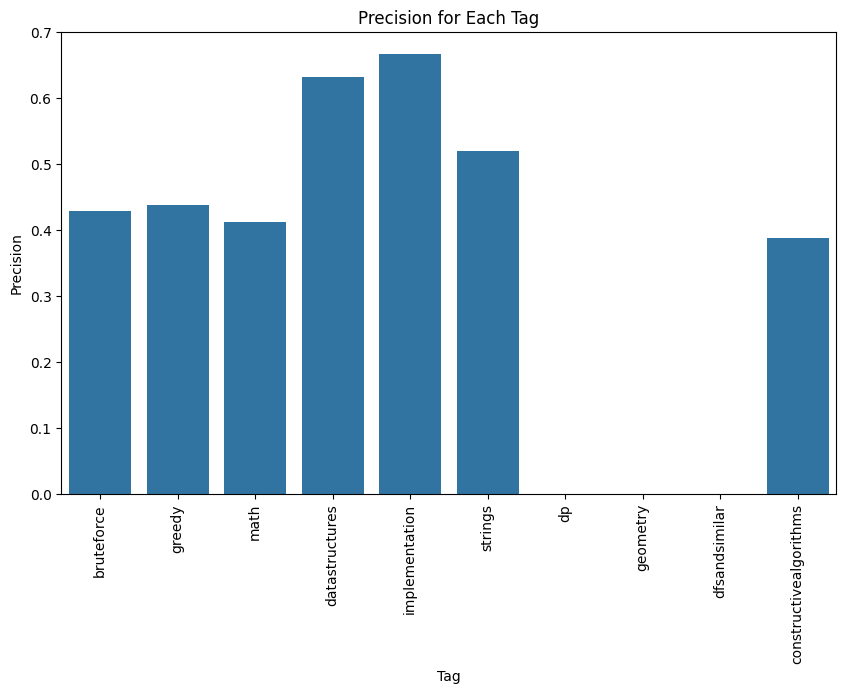

In [108]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='precision', data=report_df)
plt.xticks(rotation=90)
plt.title('Precision for Each Tag')
plt.xlabel('Tag')
plt.ylabel('Precision')
plt.show()

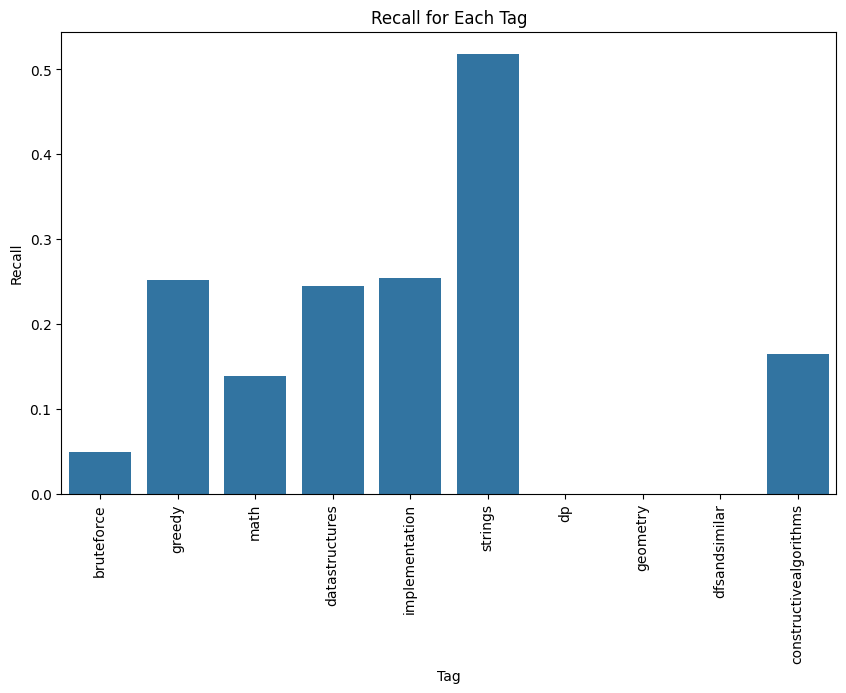

In [109]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='recall', data=report_df)
plt.xticks(rotation=90)
plt.title('Recall for Each Tag')
plt.xlabel('Tag')
plt.ylabel('Recall')
plt.show()

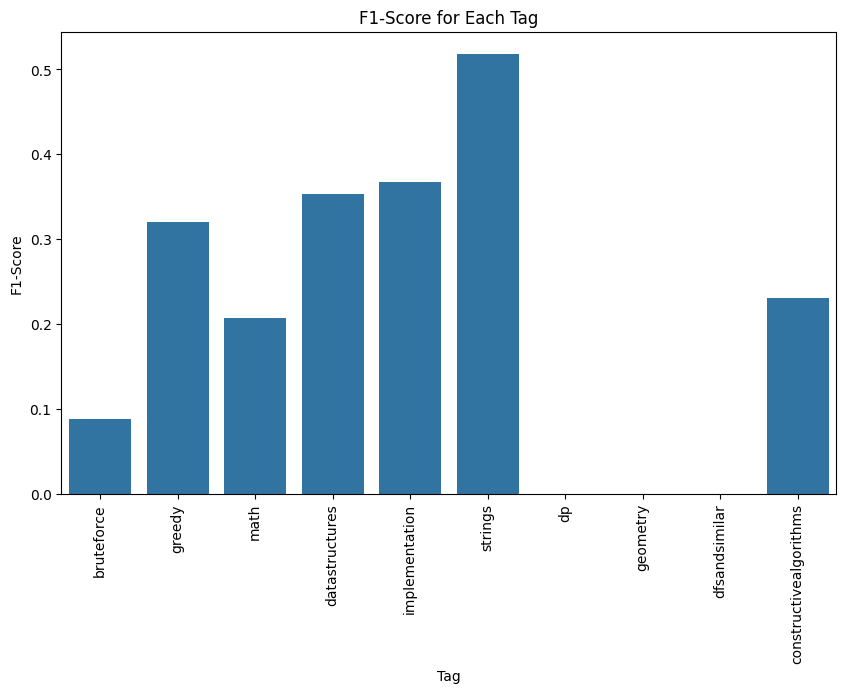

In [110]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='f1-score', data=report_df)
plt.xticks(rotation=90)
plt.title('F1-Score for Each Tag')
plt.xlabel('Tag')
plt.ylabel('F1-Score')
plt.show()

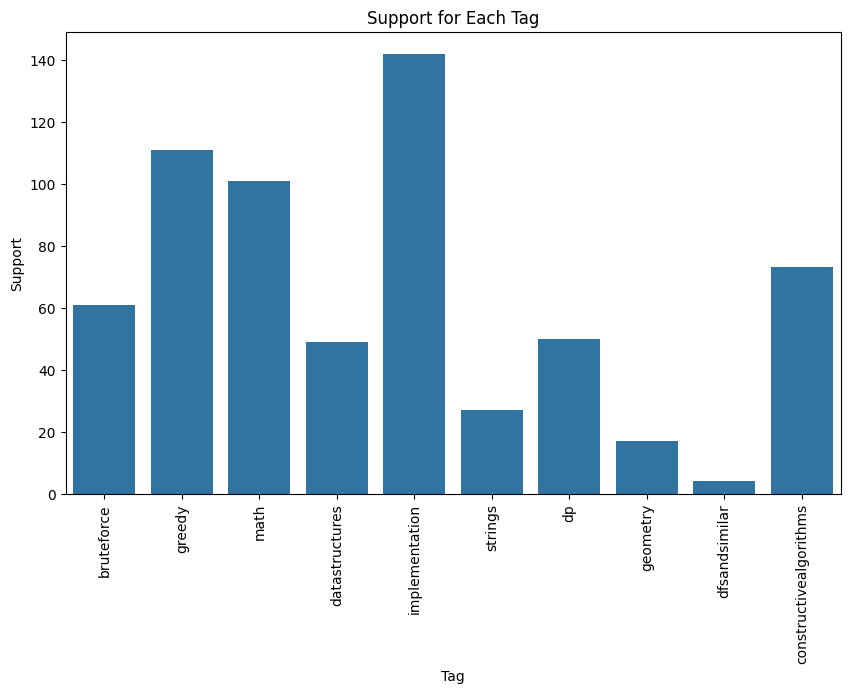

In [111]:
plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y='support', data=report_df)
plt.xticks(rotation=90)
plt.title('Support for Each Tag')
plt.xlabel('Tag')
plt.ylabel('Support')
plt.show()